In [122]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from random import choice

In [123]:
f = h5py.File('second_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [124]:
rawdata.shape

(100000, 4104)

## I am going to assume we can determine the window around the peak fairly well (1%)

In [125]:
### Define function that turns the edges of the wavelengths and 
### number of samples and position into (1+z) under the assumption it was HII

def con_pos2opz(index, leftedge,rightedge,num):
    return (index/num*(rightedge-leftedge)+leftedge)/(6562.8/1e4)

def con_opz2pos(opz, leftedge,rightedge,num):
    return (opz*(6562.8/1e4)-leftedge)/(rightedge-leftedge)*num


1437.4791754741323


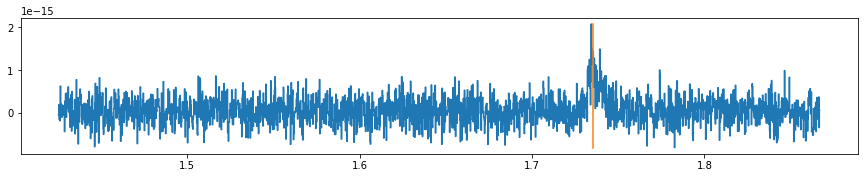

In [126]:
toshow = 1
offset = 0
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    x = rawdata[i+offset][   0:2048]
    y = rawdata[i+offset][2048:4096]
    plt.plot(x,y,drawstyle='steps-mid')
    opz = 1 + rawdata[i+offset][4096]
    guess = 6562.8/1e4*opz
    pos = con_opz2pos(opz,rawdata[i+offset,0],rawdata[i+offset,2047],2048)
    print(pos)
    plt.plot([guess,guess],[np.min(y),np.max(y)])
plt.show()

In [127]:
nconvert = len(rawdata)
#nconvert = 20
window = 200
resampledx = np.zeros((nconvert,int(2*window+1)))
resampledy = np.zeros((nconvert,int(2*window+1)))

for i in tqdm.tqdm(range(nconvert)):   
    y0 = rawdata[i][2048:4096]
    x0 = rawdata[i][   0:2048]
    opz = 1 + rawdata[i][4096]
    posc = int(np.round(con_opz2pos(opz,x0[0],x0[-1],2048)))
    posc = np.max([window,posc])
    posc = np.min([posc,2047-window])
    posh = posc + window
    posl = posc - window

    y1 = y0[posl:posh+1]
    x1 = x0[posl:posh+1]
    
    ym = np.mean(y0)
    yv = np.var(y0)
    
    #print(posc,posl,posh,posh-posl)
    resampledy[i] = (y1-ym)/np.sqrt(yv)
    resampledx[i] = x1
    

100%|██████████| 100000/100000 [00:09<00:00, 10645.07it/s]


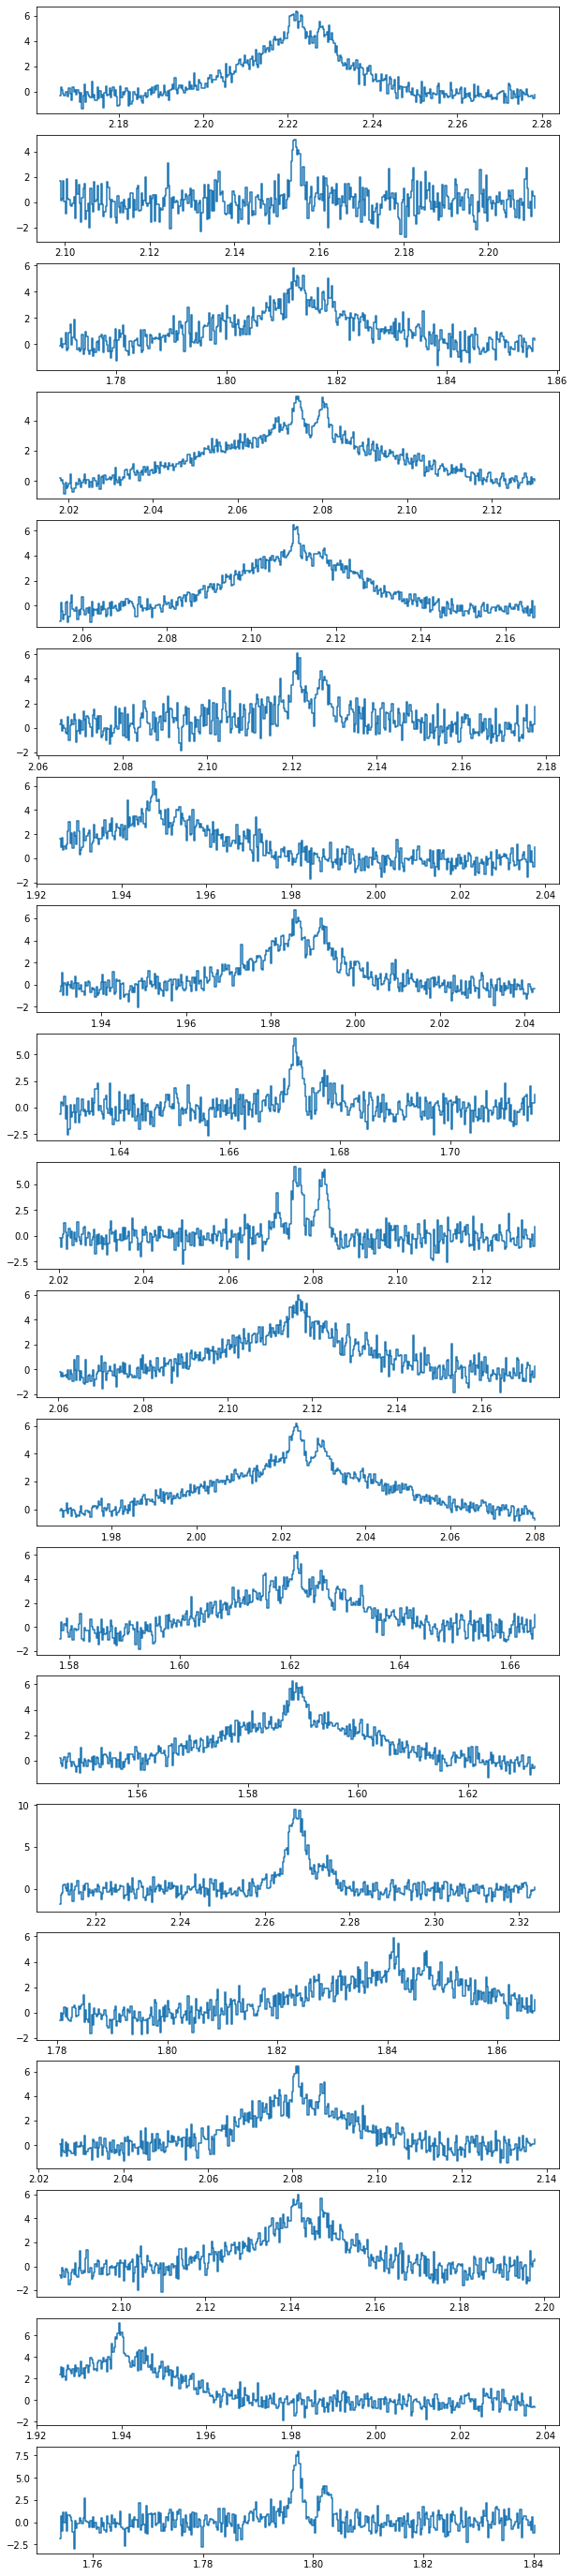

In [101]:
toshow = 20
offset = 0
plt.figure(figsize=(10,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(resampledx[i],resampledy[i],drawstyle='steps-mid')
plt.show()

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
import keras

## Split data into training and evaluation

NN = len(resampledy)
train_frac = 0.5
train_N = int(train_frac * NN)

## Define test and training data

trainx = resampledy[0:train_N]
trainy = rawdata[0:train_N,4103]
testx = resampledy[train_N:]
testy = rawdata[train_N:,4103]

In [142]:
model_001 = Sequential()
model_001.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_001.add(Dense(400, activation='relu'))
model_001.add(Dense(8, activation='relu'))
model_001.add(Dense(1, activation='sigmoid'))
model_001.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [143]:
history_001_1 = model_001.fit(trainx, trainy, epochs=50, batch_size=16,validation_split=0.1)

Epoch 1/50
2813/2813 [==============================] - 6s 2ms/step - loss: 0.0501 - accuracy: 0.9833 - val_loss: 0.0185 - val_accuracy: 0.9944
Epoch 2/50
2813/2813 [==============================] - 6s 2ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.0255 - val_accuracy: 0.9932
Epoch 3/50
2813/2813 [==============================] - 6s 2ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0191 - val_accuracy: 0.9940
Epoch 4/50
2813/2813 [==============================] - 6s 2ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0346 - val_accuracy: 0.9922
Epoch 5/50
2813/2813 [==============================] - 6s 2ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0369 - val_accuracy: 0.9930
Epoch 6/50
2813/2813 [==============================] - 8s 3ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0496 - val_accuracy: 0.9938
Epoch 7/50
2813/2813 [==============================] - 10s 4ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0319 - val_accuracy

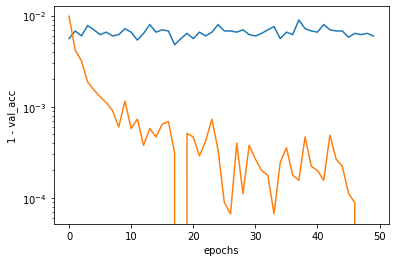

In [145]:
plt.semilogy(1.0-np.array(history_001_1.history['val_accuracy']),label='run01_val_acc')
plt.semilogy(1.0-np.array(history_001_1.history['accuracy']),label='run01_acc')
plt.xlabel('epochs')
plt.ylabel('1 - val_acc')
plt.show()

In [150]:
_, accuracy = model_001.evaluate(testx, testy)
print('Accuracy: %.2f' % (accuracy*100))

1563/1563 [==============================] - 4s 3ms/step - loss: 0.1275 - accuracy: 0.9940
Accuracy: 99.40


In [151]:
predictions = np.round(model_001.predict(testx))[:,0]

In [152]:
mask = ((predictions-testy) != 0)

In [153]:
predictions.shape

(50000,)

In [154]:
failedspectra = testx[mask]
failedtruth   = testy[mask]
failedpred    = predictions[mask]

In [156]:
np.sum(mask*1.0)

302.0

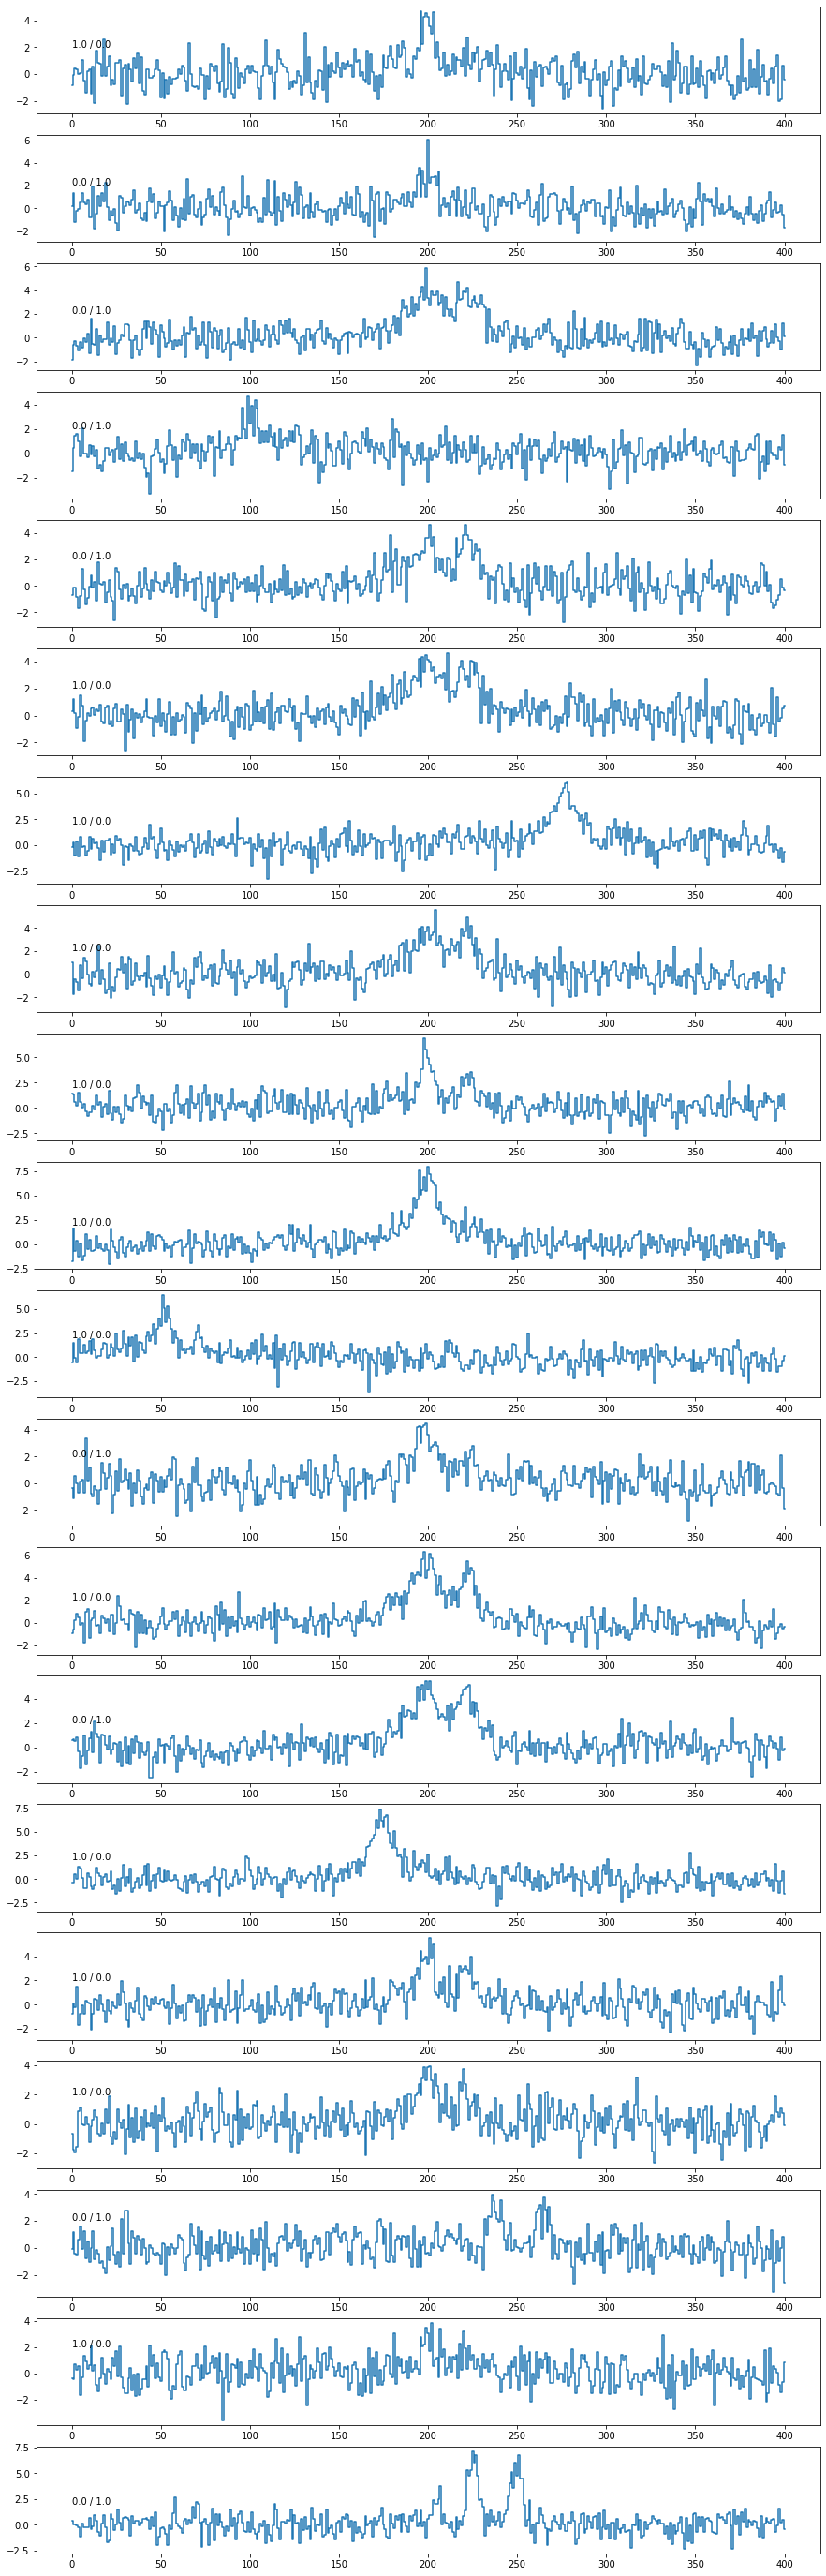

In [159]:
toshow = 20
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    y = failedspectra[i]
    
    plt.plot(y,drawstyle='steps-mid')
    plt.text(0,2.,str(failedtruth[i])+" / "+str(failedpred[i]))
plt.show()
                  